In [3]:
import numpy as np
import math as m

import matplotlib.pyplot as plt

# Set general font size
plt.rcParams['font.size'] = '16'

In [10]:
PATH = "Data/"
pose_data = "pose_data_current.txt"
visual_odometry_estimation = "vo_pose_current.txt"


In [12]:
def plot_traj(gtx, gty, est_x, est_y, estimator, color, fig_name):
  fig, axs = plt.subplots(1, figsize=(15,15))
  axs.set_aspect('equal')

  axs.plot(gtx, gty, 'o-', color='r', label = "Ground truth")
  axs.plot(est_x, est_y, 'o-', color=color, label = estimator)

  axs.set_xlabel('x (m)')
  axs.set_ylabel('y (m)')
  plt.legend()

  plt.savefig(fig_name)
  plt.show()

# 1. LAGO SLAM

In [13]:
# checks for any Nan in the line
def isNan(delta_x, delta_y, yaw, x, y):
  if(np.isnan(float(delta_x)) or np.isnan(float(delta_y)) or np.isnan(float(yaw)) or np.isnan(float(x)) or np.isnan(float(y))):
    return True
  return False

# parses the input file
def parseFile(filename):
  del_l = []
  gtx = []
  gty = []
  theta_vector = []
  # open the file
  with open(filename,"r") as file:
    line = file.readline()
    first_line = True
    R = None
    t = None
    H = None
    while(line):
      data = line.split(",")
      delta_x, delta_y, yaw, x, y = [float(i) for i in data]
      if isNan(delta_x, delta_y, yaw, x, y):
        break

      if first_line:
        first_line = False
        R = np.array([[np.cos(yaw), -np.sin(yaw)],
                      [np.sin(yaw), np.cos(yaw)]])
        R = R.T
        t = np.array([[x],[y]])
        t = -np.dot(R,t)

        H = np.array([[R[0,0], R[0,1], t[0]],
                      [R[1,0], R[1,1], t[1]],
                      [0     , 0     , 1  ]])
        x = 0
        y = 0
      else:
        state = np.array([[x],[y],[1]])
        state = np.dot(H, state)
        x = float(state[0])
        y = float(state[1])

      del_l.append(delta_x)
      del_l.append(delta_y)
      theta_vector.append(yaw)
      gtx.append(x)
      gty.append(y)

      line = file.readline()

  # convert to numpy array
  del_l = np.array(del_l)

  return del_l, theta_vector, gtx, gty


# returns A_2 as described in the LAGO paper
def compute_A_2(numEdges):
  A_2 = np.zeros((2 * numEdges,2 * numEdges))

  j = 0
  for i in range(2*numEdges):
    A_2[i][j] = 1
    if(j + 2 < 2*numEdges):
      A_2[i][j+2] = -1
    j+=1

  return A_2


# returns R star as defined in the LAGO paper
def compute_R_star(theta_vector):
  theta_size = len(theta_vector)
  mat_size = 2 * theta_size

  R_star = np.eye(mat_size)

  # populate R_star
  for i in range(theta_size):
    k = i + 1
    R_star[2*k - 2, 2*k - 2] = m.cos(theta_vector[i])
    R_star[2*k - 2, 2*k - 1] = -m.sin(theta_vector[i])
    R_star[2*k - 1, 2*k - 2] = m.sin(theta_vector[i])
    R_star[2*k - 1, 2*k - 1] = m.cos(theta_vector[i])

  return R_star


# returns P_del_l as defined in the LAGO paper
def compute_PDelL(numEdges):
  P =  0.1 * np.eye(numEdges * 2)

  return P


# returns P_del_g as defined in the LAGO paper
def compute_PDelG(numEdges, R_star):
  P_del_l = compute_PDelL(numEdges)
  P_del_g = np.dot(np.dot(R_star, P_del_l), R_star.T)

  return P_del_g


# returns del_g
def compute_DelG(del_l, R_star):
  del_g = np.dot(R_star, del_l)

  return del_g


def computeOptimalPoseConfig(A_2, P_del_g, del_g):
  A_2Pinv = np.dot(A_2, np.linalg.inv(P_del_g))
  invA_2PinvA_2T = np.linalg.inv(np.dot(A_2Pinv, A_2.T))
  A_2PinvDelg = np.dot(A_2Pinv, del_g)
  p_star = np.dot(invA_2PinvA_2T, A_2PinvDelg)

  return p_star


def getCordinatesFrompstar(p_star):
  lago_x = p_star[::2]
  lago_y = p_star[1::2]

  return lago_x, lago_y

In [15]:
#extract data
del_l, theta_vector, gtx, gty = parseFile(filename=PATH + pose_data)
numEdges = del_l.shape[0] // 2

In [16]:
# precompute values
R_star = compute_R_star(theta_vector)
A_2 = compute_A_2(numEdges)
P_del_l = compute_PDelL(numEdges)
P_del_g = compute_PDelG(numEdges, R_star)
del_g = compute_DelG(del_l, R_star)

In [17]:
p_star = computeOptimalPoseConfig(A_2, P_del_g, del_g)
refined_x, refined_y = getCordinatesFrompstar(p_star)

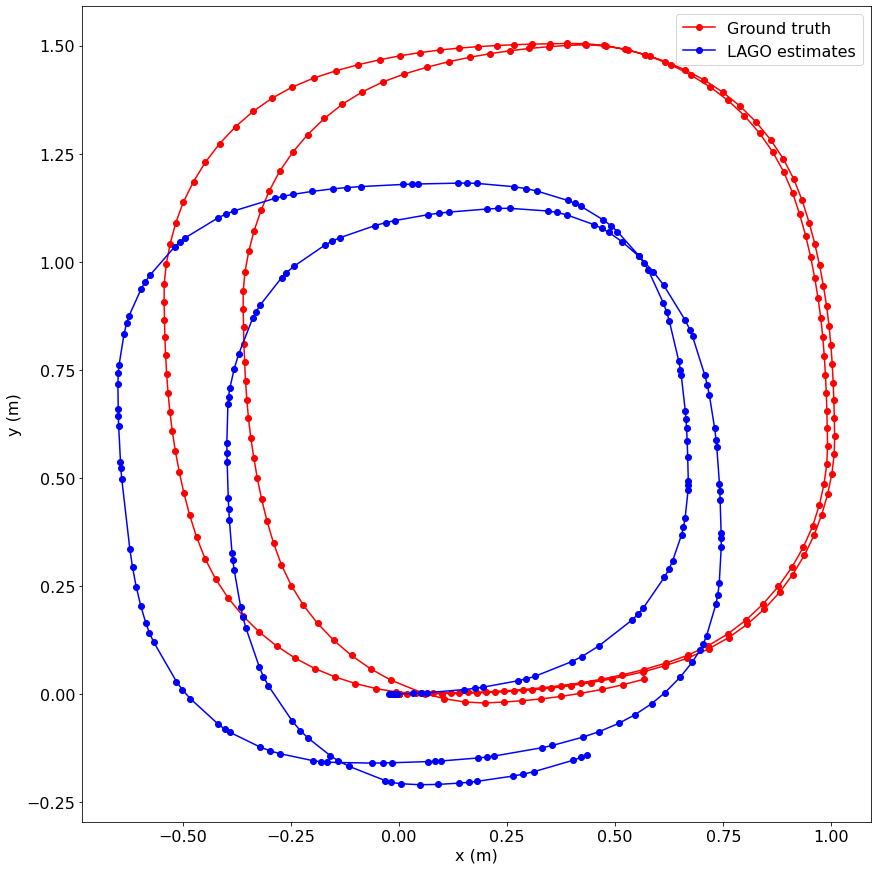

In [18]:
plot_traj(gtx, gty, refined_x, refined_y, estimator='LAGO estimates', color='b', fig_name=PATH+'fig1.png')


# 2. Visual Odometry estimation

In [19]:
def readVOestimates(filename):
  vox = []
  voy = []
  vo_yaw = []
  with open(filename, "r") as file:
    line = file.readline()
    while(line):
      data = line.split(",")
      x, y, yaw = data
      vox.append(float(x))
      voy.append(float(y))
      vo_yaw.append(float(yaw))
      line = file.readline()

  return vox, voy, vo_yaw


def parseVirtualDel(vox, voy, vo_yaw):
  virtual_del_l = []
  virtual_theta_vector = []
  for i in range(0, len(vox)- 1):
    # form a vector
    dvo = np.array([[vox[i + 1] - vox[i]],
                    [voy[i + 1] - voy[i]]])
    # form the rotation matrix
    Rot = np.array([[np.cos(vo_yaw[i]), -np.sin(vo_yaw[i])],
                    [np.sin(vo_yaw[i]), np.cos(vo_yaw[i])]])

    dvo_relative = np.dot(Rot.T, dvo)
    dx = float(dvo_relative[0])
    dy = float(dvo_relative[1])
    virtual_del_l.append(dx)
    virtual_del_l.append(dy)
    virtual_theta_vector.append(vo_yaw[i])

  virtual_del_l = np.array(virtual_del_l)
  
  return virtual_del_l, virtual_theta_vector


In [20]:
#extract data
vox, voy, vo_yaw = readVOestimates(filename=PATH+visual_odometry_estimation)
virtual_del_l, virtual_theta_vector = parseVirtualDel(vox, voy, vo_yaw)

In [21]:
virtual_numEdges = virtual_del_l.shape[0] // 2
virtual_Rstar = compute_R_star(virtual_theta_vector)
virtual_A2 = compute_A_2(virtual_numEdges)
virtual_P_del_l = compute_PDelL(virtual_numEdges)
virtual_P_del_g = compute_PDelG(virtual_numEdges, virtual_Rstar)
virtual_del_g = compute_DelG(virtual_del_l, virtual_Rstar)

In [22]:
virtual_p_star = computeOptimalPoseConfig(virtual_A2, virtual_P_del_g, virtual_del_g)
vo_x, vo_y = getCordinatesFrompstar(virtual_p_star)

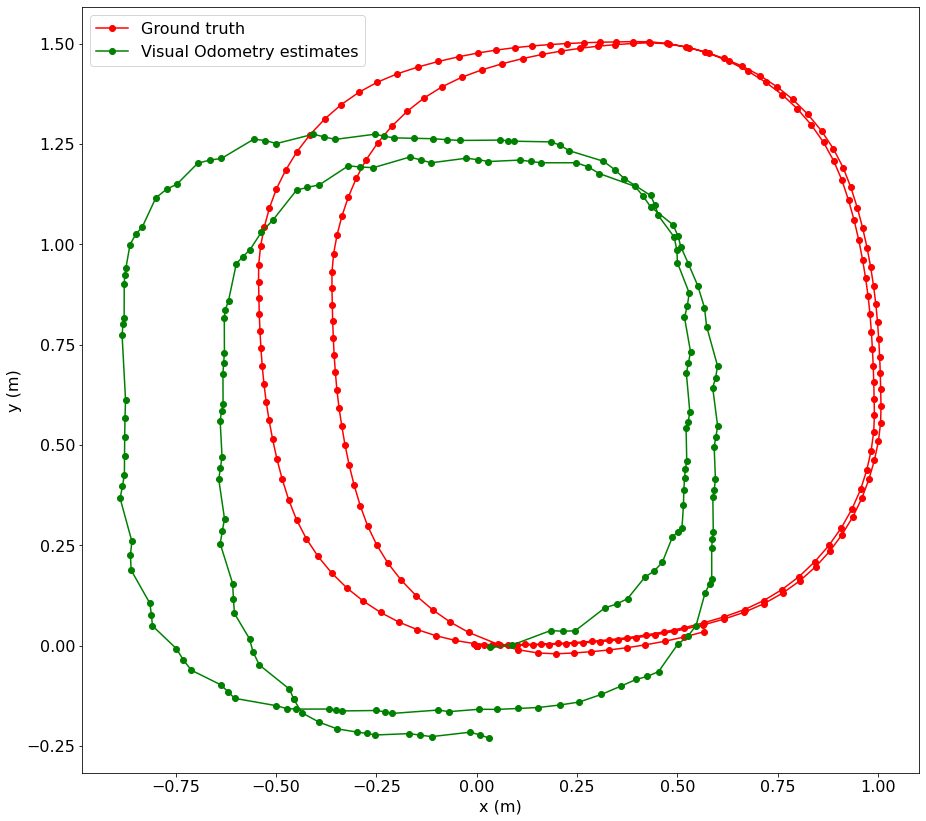

In [23]:
# plot_traj(gtx, gty, vox, voy)
plot_traj(gtx, gty, vo_x, vo_y, estimator="Visual Odometry estimates", color='g', fig_name=PATH+'fig2.png')


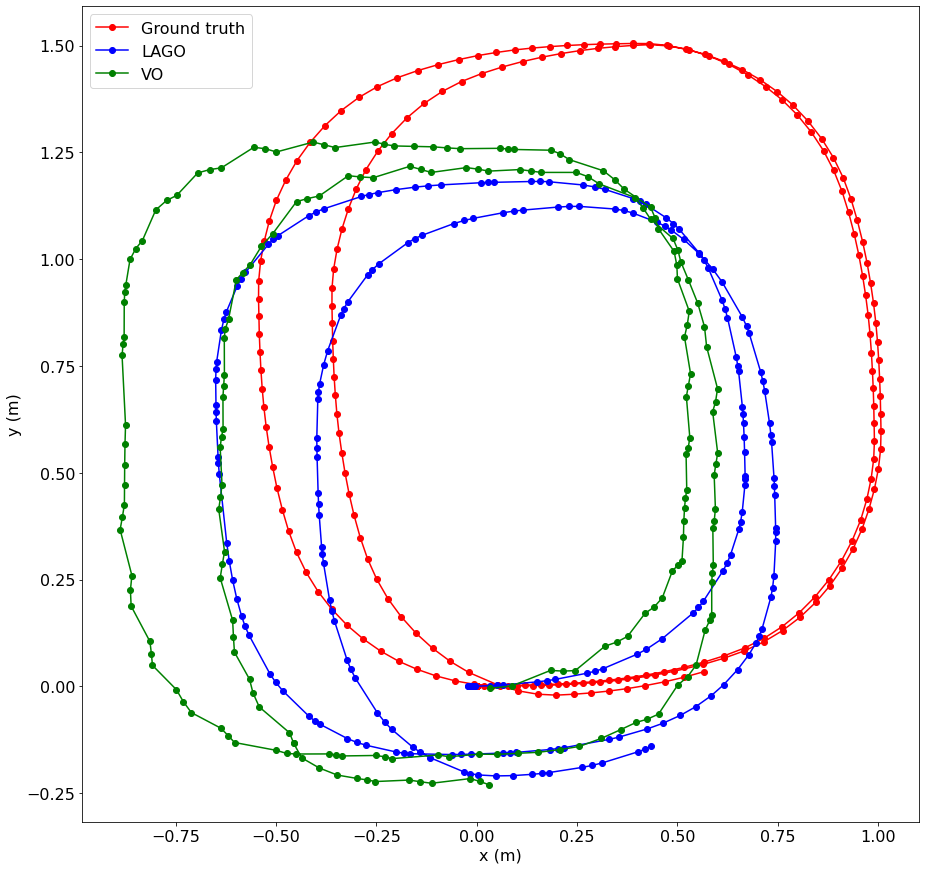

In [24]:
plt.figure(figsize=(15, 15))

plt.plot(gtx, gty, 'o-', color='r', label = "Ground truth")
plt.plot(refined_x, refined_y, 'o-', color='b', label = "LAGO")
plt.plot(vo_x, vo_y, 'o-', color='g', label = "VO")

plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.legend()

plt.savefig(PATH+'fig3.png')


plt.show()

